In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, datasets

In [4]:
import PIL
import PIL.Image

In [7]:
meta_df = pd.read_csv('archive/Meta.csv')
meta_df.head()

,Path,ClassId,ShapeId,ColorId,SignId
0,Meta/27.png,27,0,0,1.32
1,Meta/0.png,0,1,0,3.29
2,Meta/1.png,1,1,0,3.29
3,Meta/10.png,10,1,0,3.27
4,Meta/11.png,11,0,0,1.22


In [8]:
train_df = pd.read_csv('archive/Train.csv')
train_df.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,27,26,5,5,22,20,20,Train/20/00020_00000_00000.png
1,28,27,5,6,23,22,20,Train/20/00020_00000_00001.png
2,29,26,6,5,24,21,20,Train/20/00020_00000_00002.png
3,28,27,5,6,23,22,20,Train/20/00020_00000_00003.png
4,28,26,5,5,23,21,20,Train/20/00020_00000_00004.png


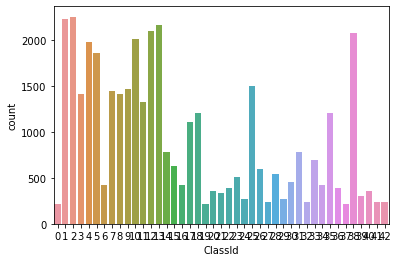

In [9]:
sns.countplot(train_df.ClassId,orient='h')
plt.show()

In [10]:
root = 'archive'
path = train_df.iloc[0,-1]
full_path = root+'/'+path
full_path

'archive/Train/20/00020_00000_00000.png'

In [12]:
training_path = root+'/'+'train'

In [13]:
batch_size=32
image_size = (180, 180)
train_ds = tf.keras.utils.image_dataset_from_directory(training_path,
                                            batch_size=batch_size, 
                                            image_size=image_size, 
                                            subset='training',
                                            validation_split=0.2,
                                            seed=123)

Found 39209 files belonging to 43 classes.
Using 31368 files for training.


In [21]:
validation_ds = tf.keras.utils.image_dataset_from_directory(training_path,
                                                           batch_size=batch_size,
                                                           image_size=image_size,
                                                           subset='validation',
                                                           validation_split=0.2,
                                                           seed=123)

Found 39209 files belonging to 43 classes.
Using 7841 files for validation.


In [23]:
class_names = train_ds.class_names
",".join(class_names)

'0,1,10,11,12,13,14,15,16,17,18,19,2,20,21,22,23,24,25,26,27,28,29,3,30,31,32,33,34,35,36,37,38,39,4,40,41,42,5,6,7,8,9'

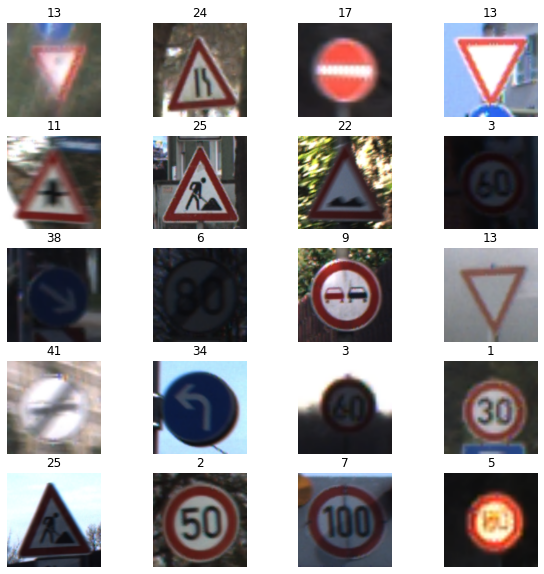

In [24]:
plt.figure(figsize=(10,10))
for images, label in train_ds.take(1):
    for i in range(20):
        ax = plt.subplot(5,4, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[label[i]])
        plt.axis('off')

In [26]:
for image_batch, label_batch in train_ds:
    print(image_batch.shape)
    print(label_batch.shape)
    break

(32, 180, 180, 3)
(32,)


In [27]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [28]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, label_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.026095646 0.42469427


In [31]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
validation_ds = validation_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [36]:
model = keras.Sequential([
    layers.Rescaling(1./255),
    layers.Conv2D(filters=32, kernel_size=3, activation='relu'),
    layers.MaxPool2D(),
    layers.Conv2D(filters=32, kernel_size=3, activation='relu'),
    layers.MaxPool2D(),
    layers.Conv2D(filters=32, kernel_size=3, activation='relu'),
    layers.MaxPool2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(class_names))
])

In [38]:
model.compile(optimizer='adam', 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy']
             )

In [39]:
history = model.fit(train_ds, validation_data=validation_ds, epochs=5)

Epoch 1/5
981/981 [==============================] - 527s 537ms/step - loss: 1.0437 - accuracy: 0.7211 - val_loss: 0.3701 - val_accuracy: 0.9047
Epoch 2/5
981/981 [==============================] - 574s 585ms/step - loss: 0.2393 - accuracy: 0.9350 - val_loss: 0.2297 - val_accuracy: 0.9462
Epoch 3/5
981/981 [==============================] - 537s 548ms/step - loss: 0.1468 - accuracy: 0.9600 - val_loss: 0.2258 - val_accuracy: 0.9480
Epoch 4/5
981/981 [==============================] - 536s 546ms/step - loss: 0.1011 - accuracy: 0.9717 - val_loss: 0.1758 - val_accuracy: 0.9638
Epoch 5/5
981/981 [==============================] - 604s 616ms/step - loss: 0.0806 - accuracy: 0.9764 - val_loss: 0.1926 - val_accuracy: 0.9584
